In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualizaciones
import re
import matplotlib.pyplot as plt
from sklearn import tree # Para los arboles de decision
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set()

In [2]:
test_df = pd.read_csv('3titanic-test.csv')
train_df = pd.read_csv('3titanic-train.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(train_df.shape)
print(train_df.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


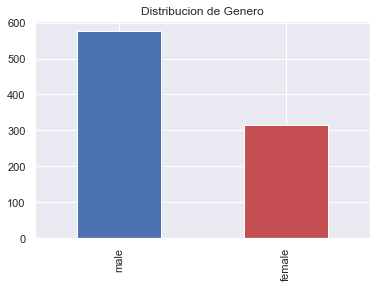

In [5]:
train_df.Sex.value_counts().plot(kind = 'bar', color = ['b', 'r'])
plt.title('Distribucion de Genero')
plt.show()

### SHOW

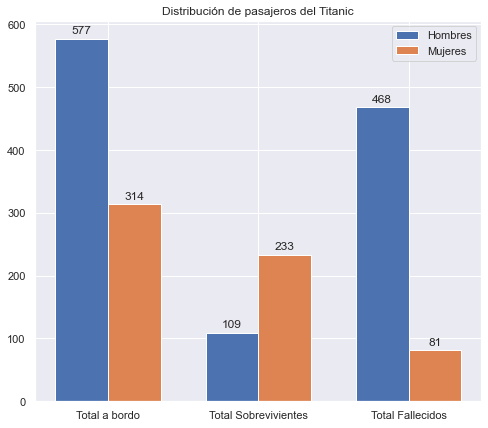

In [6]:
labels = ['Total a bordo', 'Total Sobrevivientes','Total Fallecidos']
hombres_vivos = [train_df.Sex.value_counts()[0],train_df[(train_df.Survived == 1)].Sex.value_counts()[1],train_df[(train_df.Survived == 0)].Sex.value_counts()[0]]
mujeres_vivas = [train_df.Sex.value_counts()[1],train_df[(train_df.Survived == 1)].Sex.value_counts()[0],train_df[(train_df.Survived == 0)].Sex.value_counts()[1]]

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(8,7))  # Localización de las etiquetas
rects1 = ax.bar(x - width/2, hombres_vivos, width, label='Hombres')
rects2 = ax.bar(x + width/2, mujeres_vivas, width, label='Mujeres')

# Agregue texto para etiquetas, títulos y etiquetas personalizadas del eje x, etc.
ax.set_title('Distribución de pasajeros del Titanic')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
  '''Adjunta una etiqueta de texto sobre cada barra recta, mostrando su altura.'''
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # Desplazamiento vertical de 3 puntos
                textcoords="offset points",
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

### Show

## Modificacion de Datos - Pre-proceso

In [7]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder() #Iniciar el codigo

encoder_sex = label_encoder.fit_transform(train_df['Sex'])
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# Funciones para eliminar los NULL, como vimos en INFO, Age y Embarked tienen nulls.
# Para __Age__ se uso la media, asi no altera mucho los resultados
# Para __Embarked__ se uso "S" de comodin
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna('S')

In [9]:
# Eliminar datos
# IMPORTANTE, se borra __SURVIVED__ porque es lo que queremos predecir en "predictors"
train_predictors = train_df.drop(['PassengerId','Survived','Name','Ticket', 'Cabin'], axis = 1)
# AXIS 1 = COLUMNAS      AXIS 0 = FILAS

# Aqui se separan las columnas en 2 tipos, CATEGORICAL, strings-objetos-etc y NUMERICAL, numeros

categorical_cols = [cname for cname in train_predictors.columns if 
                       train_predictors[cname].nunique() < 10 and #Que sea un datos unico
                       train_predictors[cname].dtype == 'object' #Que sea una variable categorica - Object
                    
                   ]


In [10]:
numerical_cols = [cname for cname in train_predictors.columns if
                     train_predictors[cname].dtype in ['int64', 'float64']
                 
                 ]

In [11]:
my_cols = categorical_cols + numerical_cols

train_predictors = train_predictors[my_cols] #Reemplazo de los datos, izquierda Categorica y Derecha Numerica
train_predictors.head(5)

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,male,S,3,22.0,1,0,7.2500
1,female,C,1,38.0,1,0,71.2833
2,female,S,3,26.0,0,0,7.9250
3,female,S,1,35.0,1,0,53.1000
4,male,S,3,35.0,0,0,8.0500


In [12]:
dummy_encoded_train_predictors = pd.get_dummies(train_predictors)    #Genera informacion en base a un DataFrame

In [13]:
train_df['Pclass'].value_counts()   #Ver como esta dividida la informacion

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [14]:
dummy_encoded_train_predictors.head(5)  # Los datos Categoricos ahora son BINARIOS

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


## Entrenamiento del modelo de clasificacion

In [15]:
y_target = train_df['Survived'].values
x_features_one = dummy_encoded_train_predictors.values

In [16]:
x_train, x_validation, y_train, y_validation = train_test_split(x_features_one, y_target, test_size = 0.25, random_state = 1)

In [17]:
tree_one = tree.DecisionTreeClassifier()
tree_one = tree_one.fit(x_train, y_train)

In [18]:
tree_one_accuracy = round(tree_one.score(x_validation, y_validation), 4)
print('Accuracy: %0.4f' % (tree_one_accuracy))

Accuracy: 0.7578


In [19]:
# Extenciones para ahora obtener un archivo PNG
from io import StringIO  #Generar un archivo
from IPython.display import Image, display # Imagen PNG
import pydotplus # Rutas

In [27]:
out = StringIO()
tree.export_graphviz(tree_one, out_file = out)
graph = pydotplus.graph_from_dot_data(out.getvalue())
graph.write_png("Titenic.png")

# INSTALAR GraphViz

        # Explicacion arbol
# X[n] = n corresponde al numero de la columna, en nuestro caso, en el padre, X[6] = Sexo_Masculino 0 o 1
#
#
#

True